# Random Tree Classifier on bbox coordinates/cropped images

##### Importing required libraries

In [11]:
from torch.utils.data import DataLoader
from src.utils import collate_fn
from src.dataset import CropsScikitDataset
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report

import pandas as pd
import numpy as np
import cv2

##### Preprocessing Data

In [26]:
# Function to preprocess data
def preprocess(data: tuple, frame: int = 0, mode: str = 'crop'):
    """
    Function to preprocess data to match the Random Forest Classifier from scikit-learn.
    The fitting function expects:
    
    * X: Training input samples, {array-like} of shape (n_samples, n_features), where n-dim <= 2
    * y: Target values, array-like of shape (n_samples) or (n_samples, n_outputs), where n-dim <= 2
    * sample_weight: If None, samples are equally weighted.
    
    Parameters:
    -----------
    - data: tuple, `(features, labels)`\n
    A tuple containing the features and labels of the data. 
     
    * frame: int, `default = 0`\n
    Specify a specific frame to be plotted for visualization. By default `<frame>` is set to 0, to visualize the very first frame.
     
    - mode: str, `default = "crop" | "crop", "bbox"`\n
      Used to specify whether we are preprocessing bounding box coordinates, images or image crops. By default `<mode>` is set to preprocess bounding box coordines.
    """
    
    # Separate features and labels in separate lists
    # Reshaping labels cause classifier expect dim <= 2
    # We unpack data_list2
    features, labels = data[0], data[1]
    #print(features, labels)
    #labels = np.array(labels).reshape(-1)

    # Converts each img tensor to numpy arrays
    features = [image[0].numpy() for image in features]
    org3d = features[frame]
    print("Original 3D image",features[frame].shape)
    #plt.figure(1)
    #plt.title("3d img")
    #plt.imshow(features[10])

    # We reshape the img from a 3D to 2D array
    features = [image.reshape(image.shape[0],-1) for image in features]
    print("Reshaped 2D image",features[frame].shape)
    #print(features[10])
    org2d = features[frame]
    #plt.figure(2)
    #plt.title("2d img")
    #plt.imshow(features[10], cmap='gray', aspect='auto')


    # Find the maximum height and width among all crops
    max_height = max(img.shape[0] for img in features)
    max_width = max(img.shape[1] for img in features)
    #print(f"({max_height},{max_width})")

    # Add centered padding around the crop to match max height and width
    # To counter floor divison we add +1
    features = [np.pad(img,pad_width=(((max_height - img.shape[0])//2, (max_height - img.shape[0] + 1)//2),
                                    ((max_width - img.shape[1])//2, (max_width - img.shape[1] + 1)//2)),
                    mode="constant", constant_values=0.0) for img in features]
    print("Center-Padded 2D image",features[frame].shape)
    reshaped = features[frame].reshape(max_height,max_width)
    #plt.figure(3)
    #plt.title("padded 2d img")
    #plt.imshow(features[10].reshape(max_height,max_width), cmap='gray', aspect='auto')

    # Also need to reshape the entire features list to np array
    features = np.array(features)
    samples,nx,ny = features.shape
    features = features.reshape(samples,nx*ny)
    
    return features, labels, [org3d, org2d, reshaped]

##### Setting up custom dataset and dataloader

In [28]:
le = LabelEncoder()
le.fit(['human-ride-bicycle', 'human-walk-bicycle', 'human-hold-bicycle', 'human-ride-motorcycle', 'human-walk-motorcycle'])

train_dataset = CropsScikitDataset(anno_file=r'../annotations_hoi_frame.csv', img_dir = r'../images', label_encoder=le)
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, collate_fn=collate_fn)

test_dataset = CropsScikitDataset(anno_file=r'../annotations_hoi_frame_741.csv', img_dir = r'../images', label_encoder=le)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

"""
# Iterate through dataloader
#image, target, coord = next(iter(dataloader))
#plt.imshow(image[0].numpy().transpose(1, 2 , 0))
#print(le.inverse_transform(target[0].numpy()))

# Extract features and labels
data_list = []
data_list2 = []
new_data_list = []
org_imgs = []
for batch in train_dataloader:
    crop, label, coord, _ = batch
    data_list.append((coord,label))
    data_list2.append((crop,label))
    
for batch in test_dataloader:
    crop, label, coord, org = batch
    new_data_list.append((crop,label))
    org_imgs.append(org)
#print(org_imgs)
"""

'\n# Iterate through dataloader\n#image, target, coord = next(iter(dataloader))\n#plt.imshow(image[0].numpy().transpose(1, 2 , 0))\n#print(le.inverse_transform(target[0].numpy()))\n\n# Extract features and labels\ndata_list = []\ndata_list2 = []\nnew_data_list = []\norg_imgs = []\nfor batch in train_dataloader:\n    crop, label, coord, _ = batch\n    data_list.append((coord,label))\n    data_list2.append((crop,label))\n    \nfor batch in test_dataloader:\n    crop, label, coord, org = batch\n    new_data_list.append((crop,label))\n    org_imgs.append(org)\n#print(org_imgs)\n'

##### Training loop

In [30]:
epochs = 3

for epoch in (range(epochs)):
    print(f"\nINFO: EPOCH {epoch+1}/{epochs}")
    for frames, labels, coords, _ in tqdm(train_dataloader,total=(len(train_dataloader)),leave=True):
        #print(labels, coords)
        #print(type(frames), type(labels))
        crop, label, _, = preprocess((frames,labels), frame=0, mode="crop")


INFO: EPOCH 1/3


  0%|          | 0/54 [00:00<?, ?it/s]

(tensor([[0.4353, 0.4000, 0.3529, 0.3176, 0.3098, 0.4157, 0.4941],
        [0.3882, 0.3608, 0.1686, 0.1373, 0.3059, 0.4078, 0.3765],
        [0.4863, 0.5216, 0.2784, 0.6353, 0.4275, 0.5137, 0.6157],
        [0.6588, 0.3255, 0.3686, 0.8235, 0.3804, 0.4353, 0.5765],
        [0.6118, 0.2039, 0.2353, 0.4392, 0.2627, 0.3451, 0.3608],
        [0.5765, 0.2000, 0.2196, 0.3373, 0.2863, 0.3765, 0.2353],
        [0.2745, 0.2745, 0.3059, 0.3647, 0.4000, 0.3765, 0.2314],
        [0.1882, 0.2980, 0.3373, 0.3373, 0.3490, 0.4196, 0.1922],
        [0.2510, 0.3765, 0.2235, 0.2745, 0.2706, 0.2549, 0.3922],
        [0.5294, 0.6353, 0.2902, 0.2667, 0.2902, 0.2431, 0.4627],
        [0.6549, 0.6275, 0.6314, 0.4000, 0.2510, 0.3686, 0.5765],
        [0.6275, 0.6471, 0.6196, 0.4392, 0.2941, 0.4706, 0.5725],
        [0.5882, 0.7333, 0.4863, 0.5216, 0.3373, 0.5333, 0.6471],
        [0.5961, 0.5490, 0.4039, 0.5490, 0.3490, 0.4510, 0.5843],
        [0.6863, 0.7647, 0.3255, 0.3804, 0.4902, 0.4431, 0.4863],
        [

  0%|          | 0/54 [00:00<?, ?it/s]

(tensor([[0.7059, 0.6824, 0.6196, 0.3216, 0.1843, 0.0824, 0.4392, 0.7725, 0.4863,
         0.4902, 0.5294, 0.6275, 0.7294, 0.6000, 0.7451, 0.1922, 0.7059, 0.7176,
         0.6353, 0.5608],
        [0.7412, 0.6235, 0.7608, 0.4275, 0.2941, 0.1882, 0.5020, 0.6902, 0.5529,
         0.3176, 0.5216, 0.7294, 0.6824, 0.6353, 0.7725, 0.2667, 0.5451, 0.6980,
         0.6980, 0.6314],
        [0.6667, 0.5843, 0.6431, 0.6784, 0.7373, 0.4157, 0.6706, 0.6392, 0.7843,
         0.4667, 0.6353, 0.7137, 0.6510, 0.6706, 0.7725, 0.4392, 0.3059, 0.6863,
         0.7373, 0.6353],
        [0.5137, 0.3176, 0.3765, 0.5176, 0.8196, 0.4706, 0.5608, 0.5098, 0.7490,
         0.7255, 0.7216, 0.7059, 0.7020, 0.7608, 0.7882, 0.7294, 0.1137, 0.7294,
         0.7451, 0.6471],
        [0.7569, 0.2078, 0.1569, 0.3176, 0.7333, 0.4627, 0.1137, 0.2588, 0.4235,
         0.5961, 0.7373, 0.6549, 0.6275, 0.6353, 0.7020, 0.7059, 0.1137, 0.7333,
         0.7608, 0.6902],
        [0.7961, 0.2980, 0.2353, 0.1647, 0.2157, 0.4784, 0.

  0%|          | 0/54 [00:00<?, ?it/s]

(tensor([[0.9294, 0.8941, 0.8196, 0.8000, 0.6824, 0.7098, 0.6196, 0.3490, 0.3961,
         0.4000, 0.3922, 0.3686, 0.3529, 0.3529],
        [0.7412, 0.7804, 0.9922, 0.7882, 0.3843, 0.3176, 0.5059, 0.4667, 0.3333,
         0.4235, 0.4196, 0.3647, 0.3451, 0.3333],
        [0.6824, 0.8392, 0.9176, 0.8118, 0.4196, 0.3059, 0.2471, 0.3020, 0.3882,
         0.3765, 0.3765, 0.3765, 0.3608, 0.3255],
        [0.5490, 0.8196, 0.7922, 0.7804, 0.4941, 0.3255, 0.2235, 0.4471, 0.6941,
         0.3882, 0.3765, 0.3725, 0.3490, 0.3686],
        [0.4784, 0.7255, 0.4549, 0.2510, 0.5647, 0.6549, 0.3529, 0.6627, 0.9137,
         0.3333, 0.3765, 0.3529, 0.3569, 0.3608],
        [0.5529, 0.3804, 0.1804, 0.1176, 0.1961, 0.7176, 0.7765, 0.5725, 0.5804,
         0.3647, 0.3176, 0.3451, 0.3608, 0.3373],
        [0.6902, 0.4510, 0.2588, 0.4431, 0.4157, 0.4902, 0.4157, 0.3216, 0.4157,
         0.3804, 0.3765, 0.3804, 0.3961, 0.3020],
        [0.3137, 0.1647, 0.2588, 0.3725, 0.4824, 0.6314, 0.2863, 0.2863, 0.3804,
 

KeyboardInterrupt: 

##### Training clf on bbox coordinates

(tensor([1], dtype=torch.int32),)
535
['human-ride-bicycle']
(535,)
(535, 4)
Accuracy: 0.9813084112149533
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       0.97      1.00      0.99        68
           2       1.00      0.88      0.93         8
           3       1.00      0.97      0.98        29

    accuracy                           0.98       107
   macro avg       0.99      0.96      0.98       107
weighted avg       0.98      0.98      0.98       107

Incorrect Prediction: ['human-ride-bicycle'], Actual: ['human-ride-motorcycle']
Incorrect Prediction: ['human-ride-bicycle'], Actual: ['human-walk-bicycle']


'\n### Observation ###\nDue to different shapes of the cropped frames\ni cant train the classifier on the features.\n\nI might try padding the crops?\n\nTrying to pass coordinates instead, works.\n'

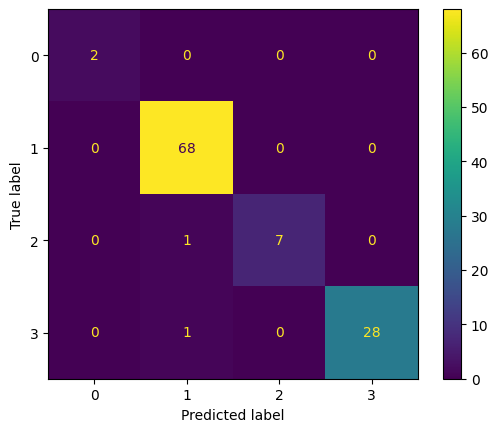

In [4]:
# Training classifier on bbox coordinates
print(data_list[533][1])
print(len(data_list))
print(le.inverse_transform(np.ravel(data_list[0][1])))

# Separate features and labels in separate lists
# Reshaping labels cause classifier expect dim <= 2
features, labels = zip(*data_list)
labels = np.array(labels).reshape(-1)
features = np.array([coord[0] for coord in features])
print(labels.shape)
#print(features)
print(features.shape)
#features = [image[0].reshape(-1).numpy() for image in features]

# Split the data into training and testing sets with random seed
seed = 1
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=seed)

# Creating a RandomForestClassifier with 100 trees with random seed
# Trying to fit the features (cropped frames of human+object)
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=seed)
rf_classifier.fit(features,labels)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))


# Compute accuracy by confusion matrix
cm_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
cm_matrix = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=rf_classifier.classes_)
cm_matrix.plot()

for pred, truth in zip(predictions, y_test):
    if pred != truth:
        print(f"Incorrect Prediction: {le.inverse_transform([pred])}, Actual: {le.inverse_transform([truth])}")

"""
### Observation ###
Due to different shapes of the cropped frames
i cant train the classifier on the features.

I might try padding the crops?

Trying to pass coordinates instead, works.
"""

##### Training clf on cropped imgs

In [ ]:
# Training classifier on cropped imgs
features, labels, plots = preprocess(data_list2, 10)

# Split the data into training and testing sets with random seed
seed = 1
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.8, random_state=seed)

# Creating a RandomForestClassifier with 10 trees with random seed
# Trying to fit the features (cropped frames of human+object)
rf_classifier = RandomForestClassifier(n_estimators=1, random_state=seed)
rf_classifier.fit(features,labels)

# Make predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluate the classifier
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test, predictions))


# Compute accuracy by confusion matrix
cm_matrix = confusion_matrix(y_test, predictions)

# Plot confusion matrix
cm_matrix = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=rf_classifier.classes_)
cm_matrix.plot()

for pred, truth in zip(predictions, y_test):
    if pred != truth:
        print(f"Incorrect Prediction: {le.inverse_transform([pred])}, Actual: {le.inverse_transform([truth])}")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("3d img")
plt.imshow(plots[0])

plt.subplot(1,3,2)
plt.title("2d img")
plt.imshow(plots[1], cmap='gray', aspect='auto')

plt.subplot(1,3,3)
plt.title("padded 2d img")
plt.imshow(plots[2], cmap='gray', aspect='auto')
plt.tight_layout()

##### Test on our data

In [ ]:
# Testing classifier on a new testset
# Preprocess data
print(len(new_data_list))
frame = int(input("frame no: "))
features, labels, plots = preprocess(new_data_list, frame)

# Make predictions on the new test set
predictions = rf_classifier.predict(features)

# Evaluate the classifier
accuracy = accuracy_score(labels, predictions)
#print(f"Accuracy: {accuracy}")
#print(classification_report(labels, predictions))


# Compute accuracy by confusion matrix
cm_matrix = confusion_matrix(labels, predictions)

# Plot confusion matrix
cm_matrix = ConfusionMatrixDisplay(confusion_matrix=cm_matrix, display_labels=rf_classifier.classes_)
#cm_matrix.plot()
for pred, truth in zip(predictions, labels):
    if pred != truth:
        print(f"Incorrect Prediction: {le.inverse_transform([pred])}, Actual: {le.inverse_transform([truth])}")

plt.figure(figsize=(10,4))
plt.subplot(1,3,1)
plt.title("3d img")
plt.imshow(plots[0])

plt.subplot(1,3,2)
plt.title("2d img")
plt.imshow(plots[1], cmap='gray', aspect='auto')

plt.subplot(1,3,3)
plt.title("padded 2d img")
plt.imshow(plots[2], cmap='gray', aspect='auto')
plt.tight_layout()

plt.figure()
plt.title(f"original img\nprediction: {le.inverse_transform([labels[10]])}")
plt.imshow(org_imgs[frame][0])